In [6]:
import sys
!{sys.executable} -m pip install pymc3

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# if I'm able to access packages install on my ncar_pylib_clone, why does python point to the jupyterhub directory?
# what is the origin of the ctsm kernel? installed while I was in the NPL clone environment?
!which python
!type python

/ncar/usr/jupyterhub/20190118/bin/python
python is /ncar/usr/jupyterhub/20190118/bin/python


In [8]:
import numpy as np

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [10]:
import corner

In [5]:
# testing the use of a package installed on my ncar_pylib_clone
from pyDOE import *
lhd = lhs(6, samples=int(2))
print(lhd)

[[0.70481664 0.95963915 0.58589155 0.67826075 0.12109413 0.40332398]
 [0.22254022 0.28848683 0.32011584 0.42541615 0.52439727 0.91003337]]


In [ ]:
# why does this hang and not complete?
import pymc3

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [13]:
#import pymc3
#import numpy as np
#import matplotlib
#import matplotlib.pyplot as plt
#import matplotlib.cm as cm
#import corner
#%matplotlib inline

## Simple MCMC notebook for two-term power law 
$$ Y = a_1 X**b_1 + a_2 X**b_2 $$
Find a1, b1, a2, b2 given some uncertain obs of Y over some values of X

In [11]:
#..Set up simple power law model function
def two_term_one_dim(a1,a2,b1,b2,xvec):
    pvec = a1*xvec**b1 + a2*xvec**b2
    return pvec

In [12]:
#..Test out this function for from values of xvec
xvec = np.linspace(0.1,100.,500)
pvec = two_term_one_dim(20.,1.,0.1,0.9,xvec)


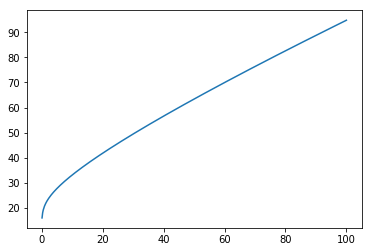

In [13]:
plt.plot(xvec,pvec)

In [14]:
# #..Define variables and priors (bounded uniform)
# a1 = pymc.Uniform('a1',0.,40.)
# a2 = pymc.Uniform('a2',0.,2.)
# b1 = pymc.Uniform('b1',-1.0,1.0)
# b2 = pymc.Uniform('b2',-2.0,2.0)

#..Define variables and priors (bounded uniform, you can try Gaussian too)
a1 = pymc.Uniform('a1',15.,25.)
a2 = pymc.Uniform('a2',0.7,1.3)
b1 = pymc.Uniform('b1',-0.3,0.3)
b2 = pymc.Uniform('b2',0.3,1.3)

#..Define the observation points and the "true" observation
xvec = np.arange(2.0,21.,2)
print(xvec)
truth = np.array([20.,1.,0.1,0.9])
ydata = two_term_one_dim(truth[0],truth[1],truth[2],truth[3],xvec)
print(ydata)

#..Define the model
@pymc.deterministic
def y_model(a1=a1, a2=a2, b1=b1, b2=b2, xvec = xvec):
    pvec = two_term_one_dim(a1,a2,b1,b2,xvec)
    return pvec

#..Define the obs error standard deviation
sigma = 0.02

#..Define the likelihood (multivariate Gaussian w/ diagnonal error variance)
y = pymc.MvNormalCov('y',mu=y_model, C=sigma**2*np.eye(xvec.shape[0]), observed=True, value=ydata)

#..Bundle everything into a dict
model = dict(a1=a1,a2=a2,b1=b1,b2=b2,y_model=y_model,y=y)

NameError: name 'pymc' is not defined

In [ ]:
#..Run using the standard sampler (metropolis sampler with burn-in) w/independent proposal
S = pymc.MCMC(model)
S.sample(iter=2000000, burn=50000)

In [ ]:
#..Run using the Adaptive Metropolis sampler (Haario 2001) w/covarying proposal
#..NOTE: you may need to run the cell two before this again to get this to work
S = pymc.MCMC(model)
S.use_step_method(pymc.AdaptiveMetropolis, [S.a1,S.a2,S.b1,S.b2], delay=10000)
S.sample(iter=2000000, burn=500000)

In [ ]:
#..Some stats
plt.hist(S.trace('y_model')[:,0],bins=40)

In [ ]:
#..Plot the posterior joint parameter PDF (as a 2D and 1D marginal corner plot)

labels  = ['$a_1$', '$a_2$','$b_1$','$b_2$']
#samples = np.vstack((S.trace('a1')[:],S.trace('a2')[:],S.trace('b1')[:],S.trace('b2')[:]))
samples = np.vstack((S.trace('a2')[:],S.trace('a1')[:],S.trace('b2')[:],S.trace('b1')[:]))
print(samples.shape)

#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(5,5,1)
#plt.plot([0,1],[0,1])
label_kwargs = {'fontsize':'20'}
#fig = triangle.corner(samples.T,labels=labels,truths=truth,label_kwargs=label_kwargs)
# fig,axes = triangle.corner(samples.T,labels=labels,truths=truth,
#                       quantiles=[.1,.5,.9],truth_color='r',
#                       show_titles=True,
#                       bins=50,
#                       label_kwargs=label_kwargs,return_axes=True)


#..NOTE the default behavior only returns fig
#fig,axes = corner.corner(samples.T,labels=labels,truths=truth,
fig = corner.corner(samples.T,labels=labels,truths=truth,
                      quantiles=[.1,.5,.9],truth_color='r',
                      show_titles=True,
                      bins=50,
                      label_kwargs=label_kwargs)
fig.set_size_inches(9,8)

fig.savefig('mcmc_twoterm_lowerr10.png',dpi=150)
#fig.suptitle('Damped Harmonic Oscillator parameter uncertainty', fontsize=22,fontweight='bold',y=1.05)
#fig.savefig('mcmc_dampharm.png',dpi=150)